In [1]:
from SymPT import *
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.linalg as la

In [2]:
#plt.style.use("classic")
cmap = plt.get_cmap('inferno')
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', weight = 'normal')
plt.rc('font', size = 18)
color_list = [cmap(i) for i in np.linspace(0, 1, 16)]
fntsize = 20
dir_images = "graphs/"

In [3]:
def get_structure(block_sizes):
    """
    Generate a block structure with specified block sizes.
    
    Parameters:
    -----------
    block_sizes : list of int
        List of block sizes for each section of the matrix
        
    Returns:
    --------
    structure : numpy.ndarray
        The generated block structure matrix
    """
    # functions for generating blocks
    block = lambda i, j: np.ones((i, j))
    zero = lambda i, j: np.zeros((i, j))
    
    
    n = len(block_sizes) # initial block structure
    structure = []
    
    for i in range(n):
        row = []
        for j in range(n):
            # Fill with zeros if i > j (lower triangle)
            if i > j:
                row.append(zero(block_sizes[i], block_sizes[j]))
            # Create block of ones for diagonal
            elif i == j:
                row.append(zero(block_sizes[i], block_sizes[j]))
            # Fill with ones for upper triangle
            else:
                row.append(block(block_sizes[i], block_sizes[j]))
        structure.append(row)
    

    structure = np.block(structure) # Convert to numpy block matrix
    
    structure = structure + structure.T # Make symmetric 
    
    return structure

# Hamiltonian

In [4]:
def substitution_rules(I, J, omegas, lambdas):
    """Returns 2 dictionaries containing substitution rules for H"""
    omega_values = np.sort([np.random.uniform(-10, 10) for _ in range(I)])  
    substitution_dict = {omegas[i]: omega_values[i] for i in range(I)}
    substitution_omegas = {omegas[i]: omega_values[i] for i in range(I)}

    lambda_index = 0
    for i in range(I):
        for j in range(i+1, J):  # Iterate only over the upper triangular part
            bound = 0.1**(lambdas[lambda_index].order) * abs(omega_values[i] - omega_values[j])            
            lambda_value = bound             
            substitution_dict[lambdas[lambda_index]] = lambda_value 
            lambda_index += 1
            
    return substitution_dict, substitution_omegas


In [5]:
def create_Hamiltonian(I, J):
    lambdas = [RDSymbol(f"\\lambda_{i}", order = 1, real = True) for i in range(int((I**2 -I))//2)]
    omegas = [RDSymbol(f"\\omega_{i}", order = 0, real = True) for i in range(I)]

    H = sp.zeros(I, J)
    lambda_index = 0
    for i in range(I):
        H[i, i] = omegas[i]  # Diagonal elements
        for j in range(i + 1, J):
            H[i, j] = lambdas[lambda_index]
            H[j, i] = lambdas[lambda_index]  # Ensure symmetry
            lambda_index += 1
    return H, omegas, lambdas

# Exact Block Diagonalization

In [6]:
def exact_block_diagonalization(Hh, mask):
    # Unitary transformation
    _, X = la.eigh(Hh)
    
    X_inv = np.linalg.inv(X)
    
    B_mask = lambda x: np.logical_not(mask) * 1 * x

    T = X @ B_mask(X_inv) @ la.fractional_matrix_power(B_mask(X) @ B_mask(X_inv), -1/2)

    return la.inv(T) @ Hh @ T


# Least Action Method

In [7]:
max_dim = 7
results_random_matrix = []
max_order = 5

for it in range(100):
    b_dims = np.random.randint(5, size=5)
    while np.sum(b_dims) > max_dim:
        b_dims = np.random.randint(5, size=5)
    structure = get_structure(b_dims)
    mask = Block(structure)

    I, J = structure.shape
    print(f"{it + 1}%. Blocks: {b_dims} - Dim {I}x{J}", end = "\r")

    H, omegas, lambdas = create_Hamiltonian(I, J)
    values, omegas_dict = substitution_rules(I,J, omegas, lambdas)

    Eff_Frame = EffectiveFrame(H, symbol_values = values, verbose = False)

    Hh = np.array(H.subs(values), dtype=float)
    exact_result = exact_block_diagonalization(Hh, structure)

    # Calculate the effective model using mask up to the second order
    Eff_Frame.solve(max_order = max_order, method = "LA", mask=mask)
    # Obtaining the result in the matrix form
    LA_result = Eff_Frame.get_H(return_form = "matrix")
    
    results_random_matrix.append([exact_result, Eff_Frame.corrections])

# Comparison with exact result

In [8]:
def fidelity(A, B):
    return np.linalg.norm(A - B) / np.linalg.norm(A)

In [9]:
errors_order = []

for i in trange(len(results_random_matrix)):
    exact_result, LA_corrections = results_random_matrix[i]
    error_order = []
    LA_res = np.zeros_like(exact_result)
    for order in range(max_order + 1):
        LA_res += np.array(LA_corrections.get(order, sp.zeros(*exact_result.shape)).evalf(), dtype=float)
        error_order.append(fidelity(exact_result, LA_res))
    errors_order.append(error_order)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:41<00:00,  3.42s/it]


Order 0
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 35 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 65 66 67 68 69 70 72 73 74 75 76
 77 78 79 82 83 84 85 86 87 89 90 91 92 93 94 95 96 98 99]
Order 1
[ 2  3  5  7  9 10 11 12 13 14 15 16 17 19 21 23 24 25 26 28 30 31 32 33
 35 37 38 39 40 42 43 44 46 48 50 51 52 53 54 55 56 57 58 60 61 62 63 65
 66 67 68 69 70 72 73 74 75 76 77 79 82 83 84 85 87 93 94 95 96 98 99]
Order 2
[16 26 38 43 55 60 68 87]
Order 3
[ 2 10 16 26 43 55 68 73]
Order 4
[10 16 24 26 43 44 68 73 79 87]
Order 5
[10 13 16 24 26 43 68 73 79 87]


Text(0, 0.5, '$\\eta(n)$')

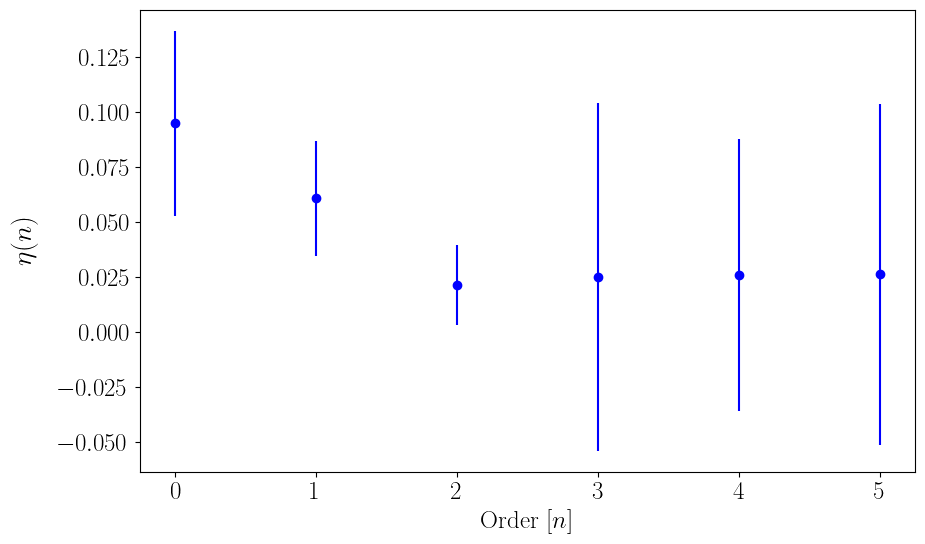

In [10]:
errors_order = np.array(errors_order, float)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for order in range(max_order + 1):
    error = np.mean(errors_order[:, order])
    print(f"Order {order}")
    print(np.arange(len(errors_order[:, order]))[errors_order[:, order] > 0.05])
    std = np.std(errors_order[:, order])
    ax.errorbar(order, error, yerr=std, fmt="o", label=f"Order {order}", color='blue')

ax.set_xlabel("Order $[n]$")
ax.set_ylabel(r"$\eta(n)$", fontsize=fntsize, labelpad=15)

In [11]:
exact, corr = results_random_matrix[94]

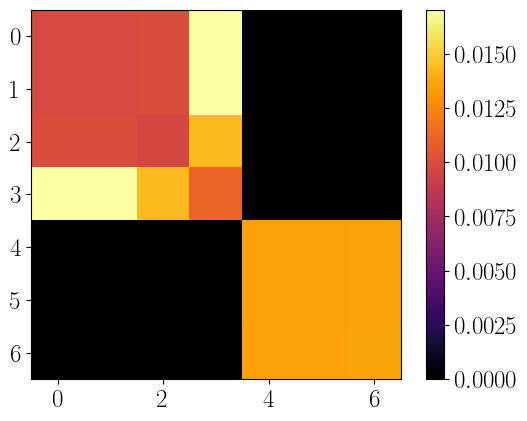

In [12]:
corr_k = lambda k : np.array((sp.Add(*[corr[i].evalf() for i in range(k + 1)])), dtype=float)
plt.imshow(np.abs(exact - corr_k(5)), cmap='inferno')
plt.colorbar()

In [13]:
sp.Matrix(corr_k(5).round(12))

Matrix([
[-6.399792347108, -0.415009792638, -0.134765668389,   0.4589146028,            0.0,            0.0,            0.0],
[-0.415009792638, -6.370432488949, -0.137133948193, 0.456528484465,            0.0,            0.0,            0.0],
[-0.134765668389, -0.137133948193, -3.859012441232, 0.248303221971,            0.0,            0.0,            0.0],
[   0.4589146028,  0.456528484465,  0.248303221971, 1.595739119767,            0.0,            0.0,            0.0],
[            0.0,             0.0,             0.0,            0.0, 8.892467737118, 0.502295079995, 0.523410296709],
[            0.0,             0.0,             0.0,            0.0, 0.502295079995, 9.326813999712, 0.490742582798],
[            0.0,             0.0,             0.0,            0.0, 0.523410296709, 0.490742582798, 9.513447240288]])

In [14]:
sp.Matrix(exact.round(12))

Matrix([
[-6.409600021146, -0.424816575929, -0.144792159235, 0.441874665596,            0.0,            0.0,            0.0],
[-0.424816575929, -6.380238331788, -0.147154333675, 0.439520756746,            0.0,            0.0,            0.0],
[-0.144792159235, -0.147154333675,  -3.86873472718, 0.233956588342,            0.0,            0.0,            0.0],
[ 0.441874665596,  0.439520756746,  0.233956588342, 1.584520234723,            0.0,            0.0,            0.0],
[            0.0,             0.0,             0.0,            0.0, 8.905931657679,  0.51579558255, 0.536975735796],
[            0.0,             0.0,             0.0,            0.0,  0.51579558255,  9.34031210831, 0.504290704662],
[            0.0,             0.0,             0.0,            0.0, 0.536975735796, 0.504290704662, 9.527039898999]])

In [15]:
np.linalg.norm(exact, ord=2)

np.float64(10.333456786669917)